In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from RunKeras import PrepareBehaviorData as pbd
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions


## Get Data and make final model from saved params

In [3]:
task_dict = {'Task1':'1 Fam Rew', 
             'Task2':'2 No Rew', 
             'Task3':'3 Fam Rew', 
             'Task4':'4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR6/'
SaveResults = os.path.join(FolderName, 'DecoderResults', 'DenseNNDecoder')

frame_lick_stop = 5154
task_numframes = {'Task1': 20000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task1 is 92
Number of PlaceCells in Task2 is 97
Number of PlaceCells in Task2a is 87
Number of PlaceCells in Task4 is 80
Number of PlaceCells in Task3 is 82


## Run Sequential NN

### Run final model from saved ground truth and model params

In [6]:
from RunKeras import SimpleDenseNN as SDNN

In [7]:
#Load ground truth
groundtruth = np.load(os.path.join(SaveResults, 'ground_truth.npz'))
X = groundtruth['X']
y = groundtruth['y']

In [8]:
#Load inputs for DenseNN from saved data
densennparams = np.load(os.path.join(SaveResults, 'Trainandvalidatedmodelparams.npz'))
dropout = densennparams['dropout'].item()
epochs = densennparams['epochs'].item()
units = densennparams['units']
batch_size = densennparams['batch_size'].item()

In [9]:
n = SDNN(dropout=dropout, epochs=epochs, hiddenlayer=1, units=units, batch_size=batch_size, verbose=1)

In [1]:
densennmodel = n.fit_model(X, y)

NameError: name 'n' is not defined

In [11]:
# serialize model to JSON
model_json = densennmodel.to_json()
with open(os.path.join(SaveResults, "Finalmodel.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
densennmodel.save_weights(os.path.join(SaveResults, "Finalmodel.h5"))

### Run model on No reward data

In [12]:
X_norew = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_norew = A.Parsed_Behavior['good_running_data'].item()['Task2']
print(np.shape(X_norew), np.shape(Y_norew))

(10058, 316) (10058, 1)


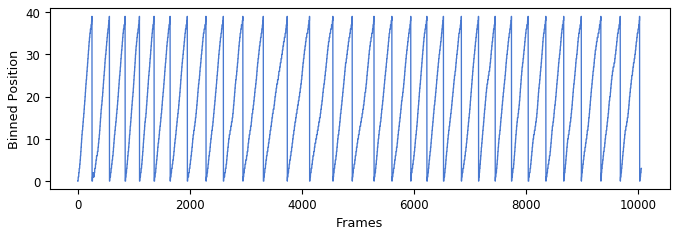

In [13]:
B = pbd(BehaviorData=Y_norew, tracklength=tracklength, trackbins=trackbins)
y_norew_cat = B.position_onehotencoded

10058/10058 [==============================] - 0s 5us/step

Accuracy of test set:: 25.17%


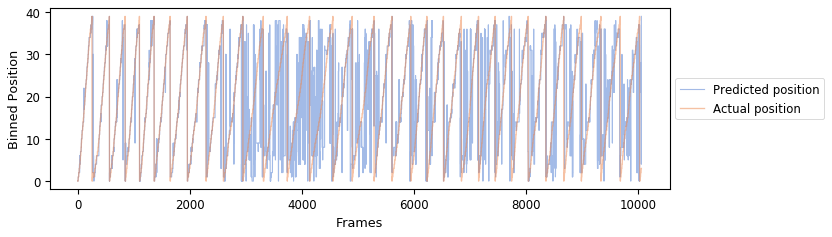

In [14]:
# evaluate the model and save evalautions
scores, ynorew_predict = n.validate_model(densennmodel, X_norew, y_norew_cat)

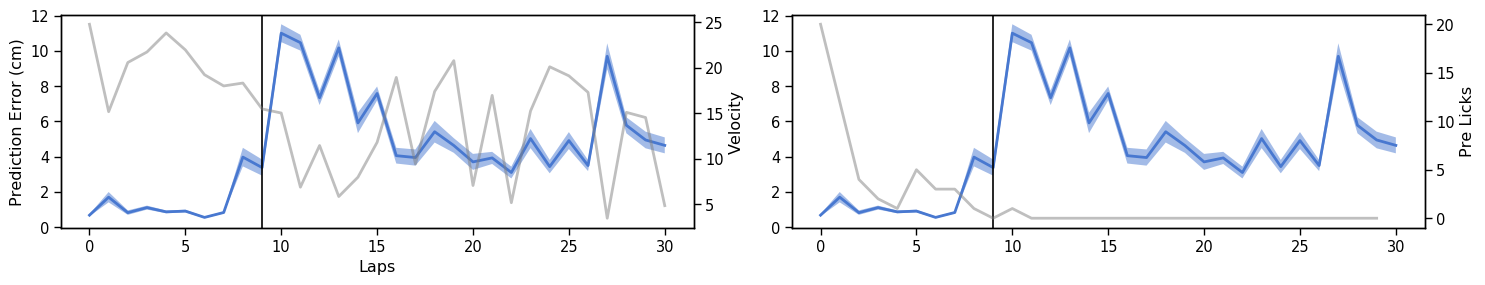

In [15]:
lapframes = [scipy.io.loadmat(os.path.join(A.FolderName, 'Behavior', p))['E'].T for p in A.PlaceFieldData if 'Task2' in p and 'Task2a' not in p][0]
Y_actual = np.argmax(y_norew_cat, 1)
Y_predicted = ynorew_predict
numlaps = A.Parsed_Behavior['numlaps'].item()['Task2']
licks = A.Parsed_Behavior['numlicks_withinreward'].item()['Task2']
velocity = tracklength/ np.asarray(A.Parsed_Behavior['actuallaps_laptime'].item()['Task2'])
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
lickstop_goodbeh_frame = np.where(lapframes == stoplicklap)[0][-1]
avg_lapdiff_norew, sem_lapdiff_norew = m.PlotLapwiseAccuracy(lapframes, Y_actual, Y_predicted, numlaps, licks, velocity, stoplicklap)

In [16]:
# Print mean correlation and mean R2
R2_before = m.get_R2(Y_actual[:lickstop_goodbeh_frame],
                     Y_predicted[:lickstop_goodbeh_frame])
rho_before = m.get_rho(
    Y_actual[:lickstop_goodbeh_frame], Y_predicted[:lickstop_goodbeh_frame])
print(f'R2 before lick stops: %.2f' % R2_before)
print(f'Rho before lick stops: %.2f' % rho_before)
R2_after = m.get_R2(Y_actual[lickstop_goodbeh_frame:],
                    Y_predicted[lickstop_goodbeh_frame:])
rho_after = m.get_rho(
    Y_actual[lickstop_goodbeh_frame:], Y_predicted[lickstop_goodbeh_frame:])
print(f'R2 after lick stops: %.2f' % R2_after)
print(f'Rho after lick stops: %.2f' % rho_after)

R2 before lick stops: 0.83
Rho before lick stops: 0.92
R2 after lick stops: 0.07
Rho after lick stops: 0.54


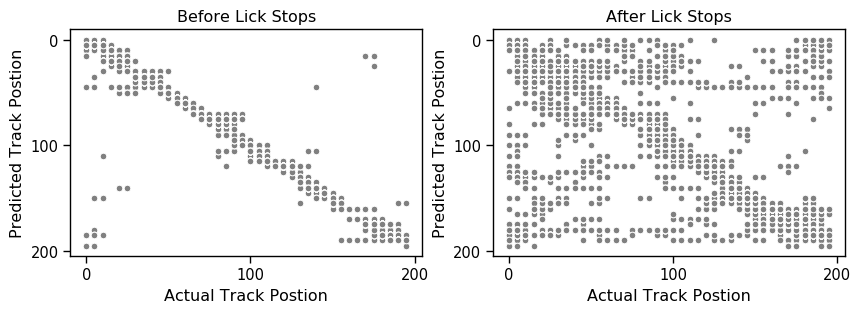

In [18]:
#Plot fitting accuracy before and after reward
m.plot_accuracy_beforeandaft_lickstops(Y_actual, Y_predicted, lickstop_goodbeh_frame, trackbins)

In [19]:
np.savez(os.path.join(SaveResults, 'FitwithNoReward.npz'), 
         y_actual=Y_actual, y_predicted=Y_predicted, 
         R2_before=R2_before, rho_before=rho_before, R2_after=R2_after, rho_after=rho_after,
         numlaps=numlaps, lapframes=lapframes,
         licks=licks, velocity=velocity, stoplicklap=stoplicklap, 
         avg_lapdiff = avg_lapdiff_norew, sem_lapdiff=sem_lapdiff_norew)

### Run Model on Reward 2

In [20]:
X_rew2 = A.Fc3data_dict['Task3'][:, A.Parsed_Behavior['good_running_index'].item()['Task3']].T
Y_rew2 = A.Parsed_Behavior['good_running_data'].item()['Task3']
print(np.shape(X_rew2), np.shape(Y_rew2))

(7072, 316) (7072, 1)


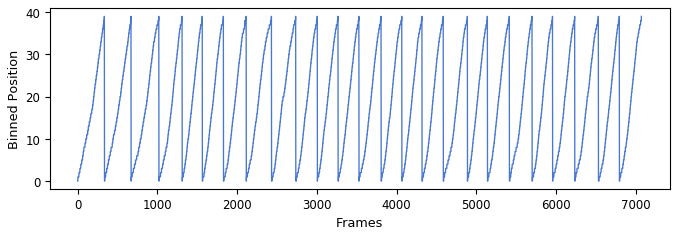

In [21]:
B = pbd(BehaviorData=Y_rew2, tracklength=tracklength, trackbins=trackbins)
y_rew2_cat = B.position_onehotencoded

7072/7072 [==============================] - 0s 6us/step

Accuracy of test set:: 27.16%


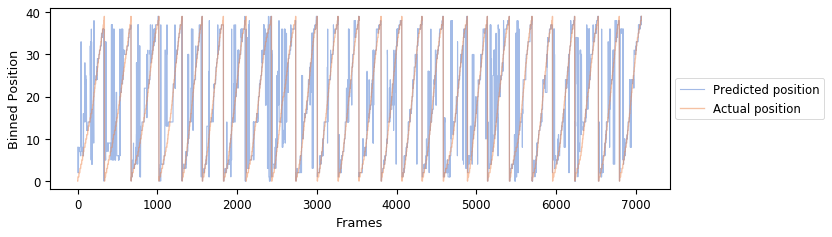

In [22]:
# evaluate the model and save evalautions
scores, yrew2_predict = n.validate_model(densennmodel, X_rew2, y_rew2_cat)# Print mean correlation and mean R2

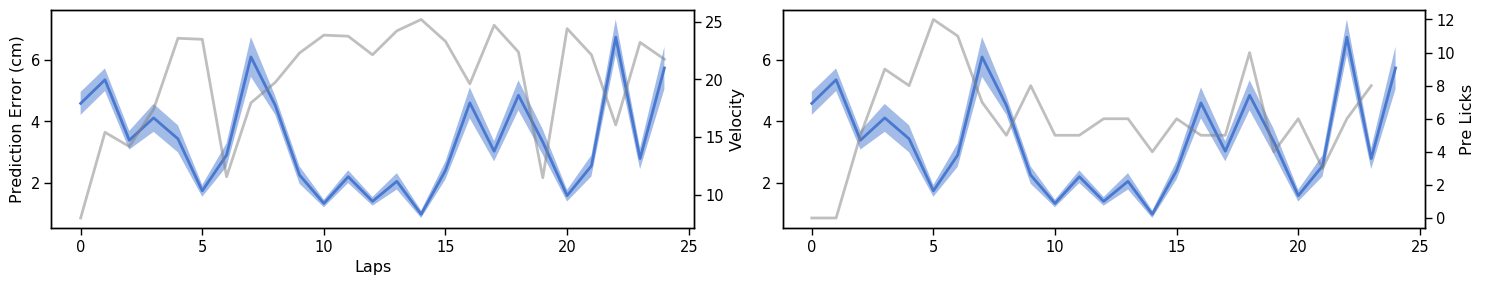

In [23]:
lapframes = [scipy.io.loadmat(os.path.join(A.FolderName, 'Behavior', p))['E'].T for p in A.PlaceFieldData if 'Task3' in p][0]
Y_actual = np.argmax(y_rew2_cat, 1)
Y_predicted = yrew2_predict
numlaps = A.Parsed_Behavior['numlaps'].item()['Task3']
licks = A.Parsed_Behavior['numlicks_withinreward'].item()['Task3']
velocity = tracklength/ np.asarray(A.Parsed_Behavior['actuallaps_laptime'].item()['Task3'])
avg_lapdiff_rew, sem_lapdiff_rew = m.PlotLapwiseAccuracy(lapframes, Y_actual, Y_predicted, numlaps, licks, velocity)

Text(0, 0.5, 'Predicted Track Postion')

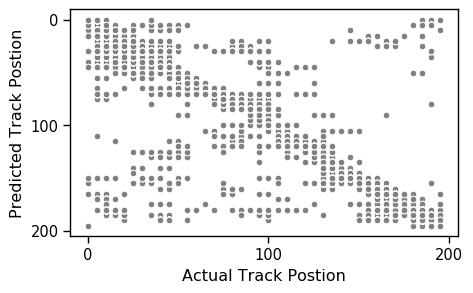

In [24]:
fs, ax1 = plt.subplots(1, figsize=(5, 3), dpi=100)
sns.scatterplot(Y_actual * trackbins, Y_predicted * trackbins, color='gray', ax=ax1)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.locator_params(nbins=4)
ax1.set_xlabel('Actual Track Postion')
ax1.set_ylabel('Predicted Track Postion')

In [26]:
# Print mean correlation and mean R2
R2_rew2 = m.get_R2(Y_actual, Y_predicted)
rho_rew2 = m.get_rho(Y_actual, Y_predicted)
print(f'R2: %.2f' %R2_rew2)
print(f'Rho: %.2f' %rho_rew2)

R2: 0.63
Rho: 0.82


In [27]:
np.savez(os.path.join(SaveResults, 'FitwithReward.npz'), 
         y_actual=Y_actual, y_predicted=Y_predicted, R2=R2_rew2, rho=rho_rew2, numlaps=numlaps, lapframes=lapframes,
        licks=licks, velocity=velocity, avg_lapdiff = avg_lapdiff_rew, sem_lapdiff=sem_lapdiff_rew)

### Run Model on Novel data

In [28]:
X_nov = A.Fc3data_dict['Task4'][:, A.Parsed_Behavior['good_running_index'].item()['Task4']].T
Y_nov = A.Parsed_Behavior['good_running_data'].item()['Task4']
print(np.shape(X_nov), np.shape(Y_nov))

(11044, 316) (11044, 1)


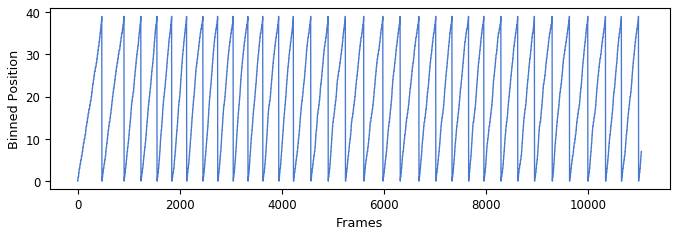

In [29]:
B = pbd(BehaviorData=Y_nov, tracklength=tracklength, trackbins=trackbins)
y_nov_cat = B.position_onehotencoded

11044/11044 [==============================] - 0s 7us/step

Accuracy of test set:: 4.14%


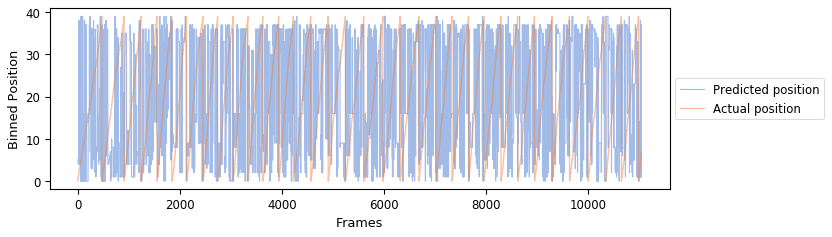

In [30]:
# evaluate the model and save evalautions
scores, ynov_predict = n.validate_model(densennmodel, X_nov, y_nov_cat)

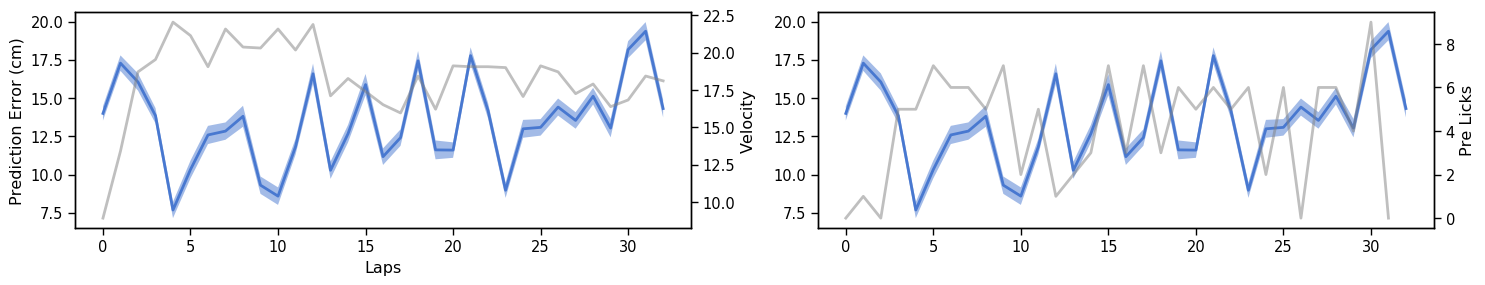

In [31]:
lapframes = [scipy.io.loadmat(os.path.join(A.FolderName, 'Behavior', p))['E'].T for p in A.PlaceFieldData if 'Task4' in p][0]
Y_actual = np.argmax(y_nov_cat, 1)
Y_predicted = ynov_predict
numlaps = A.Parsed_Behavior['numlaps'].item()['Task4']
licks = A.Parsed_Behavior['numlicks_withinreward'].item()['Task4']
velocity = tracklength/ np.asarray(A.Parsed_Behavior['actuallaps_laptime'].item()['Task4'])
avg_lapdiff_novel, sem_lapdiff_novel = m.PlotLapwiseAccuracy(lapframes, Y_actual, Y_predicted, numlaps, licks, velocity)

Text(0, 0.5, 'Predicted Track Postion')

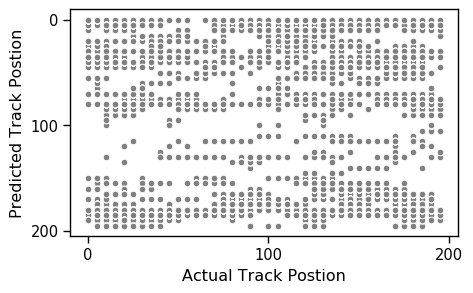

In [32]:
fs, ax1 = plt.subplots(1, figsize=(5, 3), dpi=100)
sns.scatterplot(Y_actual * trackbins, Y_predicted * trackbins, color='gray', ax=ax1)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.locator_params(nbins=4)
ax1.set_xlabel('Actual Track Postion')
ax1.set_ylabel('Predicted Track Postion')

In [33]:
# Print mean correlation and mean R2
R2_nov = m.get_R2(Y_actual, Y_predicted)
rho_nov = m.get_rho(Y_actual, Y_predicted)
print(f'R2: %.2f' %R2_nov)
print(f'Rho: %.2f' %rho_nov)

R2: -1.15
Rho: 0.11


In [34]:
np.savez(os.path.join(SaveResults, 'FitwithNovel.npz'), 
         y_actual=Y_actual, y_predicted=Y_predicted, R2=R2_nov, rho=rho_nov, numlaps=numlaps, lapframes=lapframes,
        licks=licks, velocity=velocity, avg_lapdiff = avg_lapdiff_novel, sem_lapdiff=sem_lapdiff_novel)

### Plot Average decoding error per task

In [35]:
#Get k-fold validation error for training data
controlerror = pd.read_pickle(os.path.join(SaveResults, '10-foldevaluation.pkl'))

In [36]:
mean_error_terms = [np.mean(controlerror['Y_diff'].to_list(), 1), 
                    avg_lapdiff_norew[:stoplicklap],
                    avg_lapdiff_norew[stoplicklap:],
                    avg_lapdiff_rew,
                    avg_lapdiff_novel]
plot_x_label = ['Control', 'NoRew_withlick', 'NoRew_nolick', 'Rew2', 'Novel']

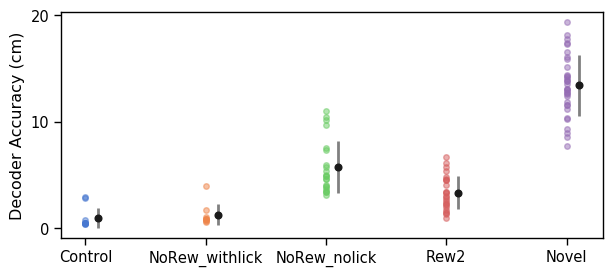

In [38]:
plt.figure(figsize=(7, 3), dpi=100)
for num, m in enumerate(mean_error_terms):
    plt.plot(np.ones(np.size(m))*num, m, '.', alpha=0.5, markersize=8)
    plt.errorbar(num+0.1, np.mean(m), yerr=np.std(m), fmt='o', capthick=2,
                 linewidth=2, ecolor='gray', color='k')
plt.locator_params(nbins=4)
plt.xticks(np.arange(np.size(plot_x_label)), plot_x_label)
plt.ylabel('Decoder Accuracy (cm)');

In [41]:
ground_truth = np.load(os.path.join(SaveResults, 'Trainandvalidatedmodelparams.npz'))

In [42]:
R2 = [ground_truth['R2'].item(), 
                    R2_before,
                    R2_after,
                    R2_rew2,
                    R2_nov]
plot_x_label = ['Control', 'NoRew_Bef', 'NoRew_Aft', 'Rew2', 'Novel']

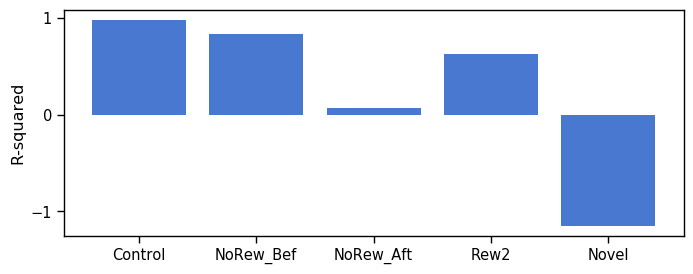

In [43]:
plt.figure(figsize=(8, 3), dpi=100)
plt.bar(np.arange(len(R2)), R2);
plt.xticks(np.arange(np.size(plot_x_label)), plot_x_label)
plt.locator_params(axis='y', nbins=3)
plt.ylabel('R-squared');